# ***Modelo de introducción en TensorFlow Lite***

Adaptado de: Train a Simple TensorFlow Lite for Microcontrollers model de

----

Este cuaderno demuestra el proceso de entrenar un modelo simple en TensorFlow, convertirlo al formato TensorFlow Lite y luego optimizarlo para microcontroladores. El objetivo es crear un modelo que se pueda implementar fácilmente en dispositivos con recursos limitados, como microcontroladores.

## Configuración

In [1]:
# Define las rutas de trabajo del modelo
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Configuración de Ambiente
Instala las dependecias

In [2]:
! pip install tensorflow==2.4.0

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4853 sha256=2fed94e0dde4c9579ce9e41c295468dda3819e580b37d8a1e8a25584d7f70224
  Stored in directory: c:\users\danie\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for wrapt: filename=wrapt-1.12.1-cp38-cp38-win_amd64.whl size=33844 sha256=fb9c4536b871840c0a9dd01c57ee6e64effcf10f57c5da772cd063c77dd3383e
  Stored in directory: c:\users\danie\appdata\local\pip\cache\wheels\5f\fd\9e\b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
Successfully built termcolor wrapt
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.4
    Uninstalling numpy-1.23.4:
      Successfully uninstalled numpy-1.23.4


ERROR: tensorflow-intel 2.13.0 has requirement absl-py>=1.0.0, but you'll have absl-py 0.15.0 which is incompatible.
ERROR: tensorflow-intel 2.13.0 has requirement flatbuffers>=23.1.21, but you'll have flatbuffers 1.12 which is incompatible.
ERROR: tensorflow-intel 2.13.0 has requirement numpy<=1.24.3,>=1.22, but you'll have numpy 1.19.5 which is incompatible.
ERROR: tensorflow-intel 2.13.0 has requirement tensorflow-estimator<2.14,>=2.13.0, but you'll have tensorflow-estimator 2.4.0 which is incompatible.
ERROR: tensorboard 2.13.0 has requirement grpcio>=1.48.2, but you'll have grpcio 1.32.0 which is incompatible.
ERROR: sqlalchemy 2.0.19 has requirement typing-extensions>=4.2.0, but you'll have typing-extensions 3.7.4.3 which is incompatible.
ERROR: pyvista 0.43.5 has requirement numpy>=1.21.0, but you'll have numpy 1.19.5 which is incompatible.
ERROR: pypdf2 3.0.1 has requirement typing_extensions>=3.10.0.0; python_version < "3.10", but you'll have typing-extensions 3.7.4.3 which is

- Importa las dependencias

In [ ]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

## Base de Datos

### 1. Generar los datos
El código de la siguiente celda generará un conjunto de valores "x" aleatorios, calculará sus valores senos y los mostrará en un gráfico.

In [ ]:
# Number of sample datapoints
SAMPLES = 1000

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values).astype(np.float32)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

### 2. Añadir Ruido
Dado que fueron generados directamente por la función seno, nuestros datos se ajustan a una curva agradable y suave.

Sin embargo, los modelos de aprendizaje automático son buenos para extraer el significado subyacente de datos confusos del mundo real. Para demostrar esto, podemos agregar algo de ruido a nuestros datos para aproximarnos a algo más realista.

En la siguiente celda, agregaremos algo de ruido aleatorio a cada valor y luego dibujaremos un nuevo gráfico:

In [ ]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

### 3. Dividir los Datos
Ahora tenemos un conjunto de datos ruidoso que se aproxima a los datos del mundo real. Usaremos esto para entrenar nuestro modelo.

Para evaluar la precisión del modelo que entrenamos, necesitaremos comparar sus predicciones con datos reales y comprobar qué tan bien coinciden. Esta evaluación ocurre durante el entrenamiento (donde se denomina validación) y después del entrenamiento (lo que se denomina prueba). En ambos casos es importante que utilicemos datos nuevos que no se hayan utilizado ya para entrenar el modelo.

Los datos se dividen de la siguiente manera:
   1. Formación: 60%
   2. Validación: 20%
   3. Pruebas: 20%

El siguiente código dividirá nuestros datos y luego trazará cada conjunto con un color diferente:

In [ ]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


## Entrenamiento

### 1. Diseñar el modelo
Vamos a construir un modelo de red neuronal simple que tomará un valor de entrada (en este caso, "x") y lo usará para predecir un valor de salida numérico (el seno de "x"). Este tipo de problema se llama _regresión_. Utilizará _capas_ de _neuronas_ para intentar aprender cualquier patrón subyacente a los datos de entrenamiento, de modo que pueda hacer predicciones.

Para empezar, definiremos dos capas. La primera capa toma una única entrada (nuestro valor "x") y la ejecuta a través de 8 neuronas. Según esta entrada, cada neurona se _activará_ hasta cierto punto según su estado interno (sus valores de _peso_ y _sesgo_). El grado de activación de una neurona se expresa como un número.

Los números de activación de nuestra primera capa se enviarán como entradas a nuestra segunda capa, que es una sola neurona. Aplicará sus propios pesos y sesgos a estas entradas y calculará su propia activación, que se generará como nuestro valor "y".

**Nota:** Para obtener más información sobre cómo funcionan las redes neuronales, puede explorar los codelabs de [Aprenda TensorFlow](https://codelabs.developers.google.com/codelabs/tensorflow-lab1-helloworld).

El código de la siguiente celda define nuestro modelo utilizando [Keras](https://www.tensorflow.org/guide/keras), la API de alto nivel de TensorFlow para crear redes de aprendizaje profundo. Una vez definida la red, la _compilamos_, especificando parámetros que determinan cómo será entrenada:

In [ ]:
# We'll use Keras to create a simple model architecture
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 8 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(keras.layers.Dense(8, activation='relu', input_shape=(1,)))

# Final layer is a single neuron, since we want to output a single value
model_1.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

### 2. Entrenar el modelo
Una vez que hayamos definido el modelo, podemos usar nuestros datos para _entrenarlo_. El entrenamiento implica pasar un valor "x" a la red neuronal, verificar en qué medida se desvía la salida de la red del valor "y" esperado y ajustar los pesos y sesgos de las neuronas para que sea más probable que la salida sea correcta la próxima vez.

El entrenamiento ejecuta este proceso en el conjunto de datos completo varias veces, y cada ejecución completa se conoce como una _época_. La cantidad de épocas que se ejecutarán durante el entrenamiento es un parámetro que podemos establecer.

Durante cada época, los datos se ejecutan a través de la red en múltiples _lotes_. En cada lote, se pasan varios datos a la red, lo que produce valores de salida. La exactitud de estos resultados se mide de forma agregada y las ponderaciones y sesgos de la red se ajustan en consecuencia, una vez por lote. El _tamaño del lote_ también es un parámetro que podemos configurar.

El código de la siguiente celda utiliza los valores "x" e "y" de nuestros datos de entrenamiento para entrenar el modelo. Se ejecuta durante 500 _épocas_, con 64 datos en cada _lote_. También pasamos algunos datos para _validación_. Como verá cuando ejecute el celular, el entrenamiento puede tardar un poco en completarse:

In [ ]:
# Train the model on our training data while validating on our validation set
history_1 = model_1.fit(x_train, y_train, epochs=500, batch_size=64,
                        validation_data=(x_validate, y_validate))

### 3. Graficar métricas

**1. Pérdida (o error cuadrático medio)**

Durante el entrenamiento, el rendimiento del modelo se mide constantemente en comparación con nuestros datos de entrenamiento y los datos de validación que reservamos anteriormente. El entrenamiento produce un registro de datos que nos dice cómo cambió el rendimiento del modelo durante el transcurso del proceso de entrenamiento.

Las siguientes celdas mostrarán algunos de esos datos en forma gráfica:

In [ ]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

El gráfico muestra la _pérdida_ (o la diferencia entre las predicciones del modelo y los datos reales) para cada época. Hay varias formas de calcular la pérdida y el método que hemos utilizado es el _error cuadrático medio_. Hay un valor de pérdida distinto dado para los datos de entrenamiento y validación.

Como podemos ver, la cantidad de pérdida disminuye rápidamente durante las primeras 25 épocas, antes de estabilizarse. ¡Esto significa que el modelo está mejorando y produciendo predicciones más precisas!

Nuestro objetivo es detener el entrenamiento cuando el modelo ya no mejora o cuando la _pérdida de entrenamiento_ es menor que la _pérdida de validación_, lo que significaría que el modelo ha aprendido a predecir los datos de entrenamiento tan bien que ya no puede generalizarlos a nuevos. datos.

Para que la parte más plana del gráfico sea más legible, omitamos las primeras 50 épocas:

In [ ]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

En el gráfico, podemos ver que la pérdida continúa reduciéndose hasta aproximadamente 200 épocas, momento en el que es mayoritariamente estable. Esto significa que no es necesario entrenar nuestra red más allá de 200 épocas.

Sin embargo, también podemos ver que el valor de pérdida más bajo sigue siendo de alrededor de 0,155. Esto significa que las predicciones de nuestra red están equivocadas en un promedio de ~15%. Además, los valores de pérdida de validación varían mucho y, a veces, son incluso mayores.

**2. Error absoluto medio**

Para obtener más información sobre el rendimiento de nuestro modelo, podemos trazar algunos datos más. Esta vez, trazaremos el _error absoluto medio_, que es otra forma de medir qué tan lejos están las predicciones de la red de los números reales:

In [ ]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Este gráfico de _error absoluto medio_ cuenta otra historia. Podemos ver que los datos de entrenamiento muestran consistentemente un error menor que los datos de validación, lo que significa que la red puede haberse sobreajustado o haber aprendido los datos de entrenamiento de manera tan rígida que no puede hacer predicciones efectivas sobre nuevos datos.

Además, los valores medios de error absoluto son bastante altos, ~0,305 en el mejor de los casos, lo que significa que algunas de las predicciones del modelo tienen al menos un 30 % de error. Un error del 30% significa que estamos muy lejos de modelar con precisión la función de onda sinusoidal.

**3. Resultados reales versus previstos**

Para obtener más información sobre lo que está sucediendo, verifiquemos sus predicciones con el conjunto de datos de prueba que reservamos anteriormente:

In [ ]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model_1.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model_1.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

¡Oh querido! El gráfico deja claro que nuestra red ha aprendido a aproximarse a la función seno de una forma muy limitada.

La rigidez de este ajuste sugiere que el modelo no tiene suficiente capacidad para aprender toda la complejidad de la función de onda sinusoidal, por lo que sólo puede aproximarla de una manera demasiado simplista. Al hacer nuestro modelo más grande, deberíamos poder mejorar su rendimiento.

## Entrenando un modelo más grande

### 1. Diseñar el modelo
Para agrandar nuestro modelo, agreguemos una capa adicional de neuronas. La siguiente celda redefine nuestro modelo de la misma manera que antes, pero con 16 neuronas en la primera capa y una capa adicional de 16 neuronas en el medio:

In [ ]:
model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))

# The new second and third layer will help the network learn more complex representations
model.add(keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

### 2. Entrenar el modelo ###

Ahora entrenaremos y guardaremos el nuevo modelo.

In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=500, batch_size=64,
                    validation_data=(x_validate, y_validate))

# Save the model to disk
model.save(MODEL_TF)

### 3. Métricas de trazado
En cada época de entrenamiento, el modelo imprime su pérdida y su error absoluto medio para el entrenamiento y la validación. Puede leer esto en el resultado anterior (tenga en cuenta que sus números exactos pueden diferir):

```
Época 500/500
10/10 [==============================] - 0s 10ms/paso - pérdida: 0.0121 - mae: 0.0882 - val_loss : 0,0115 - val_mae: 0,0865
```

Puede ver que ya hemos logrado una gran mejora: la pérdida de validación se redujo de 0,15 a 0,01 y el MAE de validación se redujo de 0,33 a 0,08.

La siguiente celda imprimirá los mismos gráficos que usamos para evaluar nuestro modelo original, pero mostrando nuestro nuevo historial de entrenamiento:

In [ ]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

¡Buenos resultados! En estos gráficos, podemos ver varias cosas interesantes:

* La pérdida general y MAE son mucho mejores que nuestra red anterior.
* Las métricas son mejores para la validación que para la capacitación, lo que significa que la red no está sobreadaptada

La razón por la que las métricas de validación son mejores que las de entrenamiento es que las métricas de validación se calculan al final de cada época, mientras que las métricas de entrenamiento se calculan a lo largo de la época, por lo que la validación ocurre en un modelo que ha sido entrenado un poco más.

¡Todo esto significa que nuestra red parece estar funcionando bien! Para confirmar, verifiquemos sus predicciones con el conjunto de datos de prueba que reservamos anteriormente:

In [ ]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

¡Mucho mejor! Las métricas de evaluación que imprimimos muestran que el modelo tiene una pérdida baja y MAE en los datos de prueba, y las predicciones se alinean visualmente con nuestros datos bastante bien.

El modelo no es perfecto; sus predicciones no forman una curva sinusoidal suave. Por ejemplo, la línea es casi recta cuando "x" está entre 4,2 y 5,2. Si quisiéramos ir más allá, podríamos intentar aumentar aún más la capacidad del modelo, tal vez utilizando algunas técnicas para defendernos del sobreajuste.

Sin embargo, una parte importante del aprendizaje automático es *saber cuándo detenerse*. Este modelo es lo suficientemente bueno para nuestro caso de uso, que consiste en hacer que algunos LED parpadeen en un patrón agradable.

## Generar un modelo de TensorFlow Lite

### 1. Generar Modelos con o sin Cuantización
Ahora tenemos un modelo aceptablemente preciso. Usaremos el [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) para convertir el modelo a un formato especial que ocupa poco espacio para usarlo en dispositivos con memoria limitada.

Dado que este modelo se implementará en un microcontrolador, ¡queremos que sea lo más pequeño posible! Una técnica para reducir el tamaño de un modelo se llama [cuantización] (https://www.tensorflow.org/lite/performance/post_training_quantization). Reduce la precisión de los pesos del modelo y posiblemente también las activaciones (salida de cada capa), lo que ahorra memoria, a menudo sin mucho impacto en la precisión. Los modelos cuantificados también funcionan más rápido, ya que los cálculos necesarios son más sencillos.

En la siguiente celda, convertiremos el modelo dos veces: una con cuantificación y otra sin cuantización.

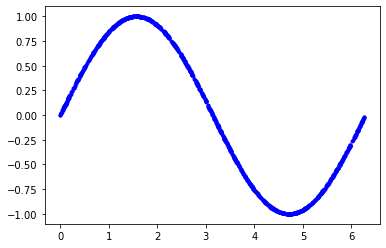

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

### 2. Comparar el rendimiento del modelo

Para demostrar que estos modelos son precisos incluso después de la conversión y cuantificación, compararemos sus predicciones y pérdidas en nuestro conjunto de datos de prueba.

**Funciones auxiliares**

Definimos las funciones "predecir" (para predicciones) y "evaluar" (para pérdidas) para los modelos TFLite. *Nota: Estos ya están incluidos en un modelo TF, pero no en un modelo TFLite.*

In [ ]:
def predict_tflite(tflite_model, x_test):
    # Prepare the test data
    x_test_ = x_test.copy()
    x_test_ = x_test_.reshape((x_test.size, 1))
    x_test_ = x_test_.astype(np.float32)

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model,
                                        experimental_op_resolver_type=tf.lite.experimental.OpResolverType.BUILTIN_REF)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # If required, quantize the input layer (from float to integer)
    input_scale, input_zero_point = input_details["quantization"]
    if (input_scale, input_zero_point) != (0.0, 0):
        x_test_ = x_test_ / input_scale + input_zero_point
        x_test_ = x_test_.astype(input_details["dtype"])

    # Invoke the interpreter
    y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
    for i in range(len(x_test_)):
        interpreter.set_tensor(input_details["index"], [x_test_[i]])
        interpreter.invoke()
        y_pred[i] = interpreter.get_tensor(output_details["index"])[0]

    # If required, dequantized the output layer (from integer to float)
    output_scale, output_zero_point = output_details["quantization"]
    if (output_scale, output_zero_point) != (0.0, 0):
        y_pred = y_pred.astype(np.float32)
        y_pred = (y_pred - output_zero_point) * output_scale

    return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
    global model
    y_pred = predict_tflite(tflite_model, x_test)
    loss_function = tf.keras.losses.get(model.loss)
    loss = loss_function(y_true, y_pred).numpy()
    return loss

**1. Predicciones**

In [ ]:
# Calculate predictions
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

In [ ]:
# Compare predictions
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual values')
plt.plot(x_test, y_test_pred_tf, 'ro', label='TF predictions')
plt.plot(x_test, y_test_pred_no_quant_tflite, 'bx', label='TFLite predictions')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='TFLite quantized predictions')
plt.legend()
plt.show()

**2. Perdida (MSE)**

In [ ]:
# Calculate loss
loss_tf, _ = model.evaluate(x_test, y_test, verbose=0)
loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
loss_tflite = evaluate_tflite(model_tflite, x_test, y_test)

In [ ]:
# Compare loss
df = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf],
     ["TensorFlow Lite", loss_no_quant_tflite],
     ["TensorFlow Lite Quantized", loss_tflite]],
     columns = ["Model", "Loss/MSE"], index="Model").round(4)
df

**3. Tamaño**

In [ ]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

In [ ]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

**Resúmen**

Podemos ver en las predicciones (gráfico) y la pérdida (tabla) que el modelo TF original, el modelo TFLite y el modelo TFLite cuantificado son lo suficientemente cercanos como para ser indistinguibles, aunque difieren en tamaño (tabla). ¡Esto implica que el modelo cuantificado (el más pequeño) está listo para usar!

*Nota: El modelo TFLite cuantificado (entero) es solo 300 bytes más pequeño que el modelo TFLite original (flotante): ¡una pequeña reducción de tamaño! Esto se debe a que el modelo ya es tan pequeño que la cuantificación tiene poco efecto. ¡Los modelos complejos con más peso pueden tener una reducción de tamaño de hasta 4 veces!*

## Generar un modelo de TensorFlow Lite para microcontroladores
Convierta el modelo cuantificado de TensorFlow Lite en un archivo fuente C que TensorFlow Lite para microcontroladores pueda cargar.

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

## Implementar en un microcontrolador

Siga las instrucciones en [hello_world](https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world) README.md para [TensorFlow Lite para microcontroladores](https: //www.tensorflow.org/lite/microcontrollers/overview) para implementar este modelo en un microcontrolador específico.

**Modelo de referencia:** Si no ha modificado este cuaderno, puede seguir las instrucciones tal como están para implementar el modelo. Consulte el directorio [`hello_world/train/models`](https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world/train/models) para acceder a los modelos. generado en este cuaderno.

**Nuevo modelo:** Si ha generado un nuevo modelo, actualice los valores asignados a las variables definidas en [`hello_world/model.cc`](https://github.com/tensorflow/tflite-micro/blob /main/tensorflow/lite/micro/examples/hello_world/model.cc) con valores mostrados después de ejecutar la siguiente celda.

In [ ]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}